# 图像分类与常用模块解读

### 数据预处理部分：

- 数据增强：torchvision中transforms模块自带功能，比较实用
- 数据预处理：torchvision中transforms也帮我们实现好了，直接调用即可
- DataLoader模块直接读取batch数据

### 网络模块设置：

- 加载预训练模型，torchvision中有很多经典网络架构，调用起来十分方便，并且可以用人家训练好的权重参数来继续训练，也就是所谓的迁移学习
- 需要注意的是别人训练好的任务跟咱们的可不是完全一样，需要把最后的head层改一改，一般也就是最后的全连接层，改成咱们自己的任务
- 训练时可以全部重头训练，也可以只训练最后咱们任务的层，因为前几层都是做特征提取的，本质任务目标是一致的

### 网络模型保存与测试
- 模型保存的时候可以带有选择性，例如在验证集中如果当前效果好则保存
- 读取模型进行实际测试


In [ ]:
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
from torch import nn
import torch.optim as optim
import torchvision
from torchvision import transforms, models, datasets    # transforms用于数据增强与预处理
import imageio
import time
import warnings
warnings.filterwarnings("ignore")
import random
import sys
import copy
import json
from PIL import Image

### 数据读取与预处理操作

In [ ]:
data_dir = './flower_data/'             # 数据集路径
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'

#### 制作好数据源：
- data_transforms中指定了所有图像预处理操作
- ImageFolder假设所有的文件按文件夹保存好，每个文件夹下面存贮同一类别的图片，文件夹的名字为分类的名字

In [7]:
data_transforms = {                 # 数据增强和数据预处理
    'train':
        transforms.Compose([            # 组合多个变换操作
        transforms.Resize([96, 96]),
        transforms.RandomRotation(45),#随机旋转，-45到45度之间随机选
        transforms.CenterCrop(64),#从中心开始裁剪
        transforms.RandomHorizontalFlip(p=0.5),#随机水平翻转 选择一个概率概率
        transforms.RandomVerticalFlip(p=0.5),#随机垂直翻转
        transforms.ColorJitter(brightness=0.2, contrast=0.1, saturation=0.1, hue=0.1),#参数1为亮度，参数2为对比度，参数3为饱和度，参数4为色相
        transforms.RandomGrayscale(p=0.025),#概率转换成灰度率，3通道就是R=G=B
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # 大数据集比如imageNet的均值，标准差
    ]),
    'valid':                        # 验证集不进行数据增强，只做预处理
        transforms.Compose([
        transforms.Resize([64, 64]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

batch_size = 128

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True) for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes

image_datasets


{'train': Dataset ImageFolder
     Number of datapoints: 6552
     Root location: ./flower_data/train
     StandardTransform
 Transform: Compose(
                Resize(size=[96, 96], interpolation=bilinear, max_size=None, antialias=True)
                RandomRotation(degrees=[-45.0, 45.0], interpolation=nearest, expand=False, fill=0)
                CenterCrop(size=(64, 64))
                RandomHorizontalFlip(p=0.5)
                RandomVerticalFlip(p=0.5)
                ColorJitter(brightness=(0.8, 1.2), contrast=(0.9, 1.1), saturation=(0.9, 1.1), hue=(-0.1, 0.1))
                RandomGrayscale(p=0.025)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'valid': Dataset ImageFolder
     Number of datapoints: 818
     Root location: ./flower_data/valid
     StandardTransform
 Transform: Compose(
                Resize(size=[64, 64], interpolation=bilinear, max_size=None, antialias=True)
                ToTe

#### 读取标签对应的实际名字

In [8]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

cat_to_name

{'21': 'fire lily',
 '3': 'canterbury bells',
 '45': 'bolero deep blue',
 '1': 'pink primrose',
 '34': 'mexican aster',
 '27': 'prince of wales feathers',
 '7': 'moon orchid',
 '16': 'globe-flower',
 '25': 'grape hyacinth',
 '26': 'corn poppy',
 '79': 'toad lily',
 '39': 'siam tulip',
 '24': 'red ginger',
 '67': 'spring crocus',
 '35': 'alpine sea holly',
 '32': 'garden phlox',
 '10': 'globe thistle',
 '6': 'tiger lily',
 '93': 'ball moss',
 '33': 'love in the mist',
 '9': 'monkshood',
 '102': 'blackberry lily',
 '14': 'spear thistle',
 '19': 'balloon flower',
 '100': 'blanket flower',
 '13': 'king protea',
 '49': 'oxeye daisy',
 '15': 'yellow iris',
 '61': 'cautleya spicata',
 '31': 'carnation',
 '64': 'silverbush',
 '68': 'bearded iris',
 '63': 'black-eyed susan',
 '69': 'windflower',
 '62': 'japanese anemone',
 '20': 'giant white arum lily',
 '38': 'great masterwort',
 '4': 'sweet pea',
 '86': 'tree mallow',
 '101': 'trumpet creeper',
 '42': 'daffodil',
 '22': 'pincushion flower',
 

### 模型加载

- 加载models中提供的模型，并且直接用训练的好权重当做初始化参数

- ***迁移学习***：在已训练好的模型参数基础上做微调

In [9]:
model_name = 'resnet'  # 可选的比较多 ['resnet', 'alexnet', 'vgg', 'squeezenet', 'densenet', 'inception']

feature_extract = True # 是否只更新最后的分类层参数

# 是否用GPU训练
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

CUDA is not available.  Training on CPU ...


In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False     # 冻结参数
        
model_ft = models.resnet18()    # 18层的能快点，条件好点的也可以选152
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### 把模型输出层改成自己的

- ResNet: (fc): Linear(in_features=512, out_features=1000, bias=True)
- 最后一层输出层的in_features不变,out_features根据任务设置

In [ ]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    
    model_ft = models.resnet18(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, 102)  # 类别数自己根据自己任务来
                            
    input_size = 64     # 输入大小根据自己配置来

    return model_ft, input_size

#### 设置哪些层需要训练

In [12]:
model_ft, input_size = initialize_model(model_name, 102, feature_extract, use_pretrained=True)

#GPU还是CPU计算
model_ft = model_ft.to(device)

# 模型保存，名字自己起
filename='checkpoint.pth'

# 是否训练所有层
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\35096/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:28<00:00, 1.67MB/s]

Params to learn:
	 fc.weight
	 fc.bias


In [13]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### 训练模块

In [ ]:
# 优化器设置
optimizer_ft = optim.Adam(params_to_update, lr=1e-2)            # params_to_update是要更新的参数
scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)    # 学习率每10个epoch衰减成原来的1/10
criterion = nn.CrossEntropyLoss()

def train_model(model, dataloaders, criterion, optimizer, num_epochs=25,filename='best.pt'):
    #咱们要算时间的
    since = time.time()
    #也要记录最好的那一次
    best_acc = 0
    #模型也得放到你的CPU或者GPU
    model.to(device)
    #训练过程中打印一堆损失和指标
    val_acc_history = []
    train_acc_history = []
    train_losses = []
    valid_losses = []
    #学习率
    LRs = [optimizer.param_groups[0]['lr']]
    #最好的那次模型，后续会变的，先初始化
    best_model_wts = copy.deepcopy(model.state_dict())
    #一个个epoch来遍历
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 训练和验证
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # 训练
            else:
                model.eval()   # 验证

            running_loss = 0.0
            running_corrects = 0

            # 把数据都取个遍
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)#放到你的CPU或GPU
                labels = labels.to(device)

                # 清零
                optimizer.zero_grad()
                # 只有训练的时候计算和更新梯度
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)
                # 训练阶段更新权重
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # 计算损失
                running_loss += loss.item() * inputs.size(0)    # 0表示batch那个维度
                running_corrects += torch.sum(preds == labels.data)     # 预测结果最大的和真实值是否一致
                


            epoch_loss = running_loss / len(dataloaders[phase].dataset)  # 算平均
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            time_elapsed = time.time() - since  # 一个epoch我浪费了多少时间
            print('Time elapsed {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            

            # 得到最好那次的模型
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                state = {
                  'state_dict': model.state_dict(),     # 字典里key就是各层的名字，值就是训练好的权重
                  'best_acc': best_acc,
                  'optimizer' : optimizer.state_dict(),
                }
                torch.save(state, filename)
            if phase == 'valid':
                val_acc_history.append(epoch_acc)
                valid_losses.append(epoch_loss)
                #scheduler.step(epoch_loss)#学习率衰减
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_losses.append(epoch_loss)
        
        print('Optimizer learning rate : {:.7f}'.format(optimizer.param_groups[0]['lr']))
        LRs.append(optimizer.param_groups[0]['lr'])
        print()
        scheduler.step()#学习率衰减

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # 训练完后用最好的一次当做模型最终的结果,等着一会测试
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, train_acc_history, valid_losses, train_losses, LRs 

In [16]:
model_ft, val_acc_history, train_acc_history, valid_losses, train_losses, LRs  = train_model(model_ft, dataloaders, criterion, optimizer_ft, num_epochs=10,)

Epoch 0/9
----------
Time elapsed 0m 42s
train Loss: 3.8196 Acc: 0.2529
Time elapsed 0m 46s
valid Loss: 3.6838 Acc: 0.2653
Optimizer learning rate : 0.0100000

Epoch 1/9
----------
Time elapsed 1m 27s
train Loss: 2.8546 Acc: 0.3929
Time elapsed 1m 31s
valid Loss: 3.7199 Acc: 0.2812
Optimizer learning rate : 0.0100000

Epoch 2/9
----------
Time elapsed 2m 11s
train Loss: 2.7210 Acc: 0.4133
Time elapsed 2m 16s
valid Loss: 3.8258 Acc: 0.2958
Optimizer learning rate : 0.0100000

Epoch 3/9
----------
Time elapsed 2m 56s
train Loss: 2.8040 Acc: 0.4316
Time elapsed 3m 2s
valid Loss: 3.8467 Acc: 0.3178
Optimizer learning rate : 0.0100000

Epoch 4/9
----------
Time elapsed 3m 47s
train Loss: 2.7679 Acc: 0.4382
Time elapsed 3m 51s
valid Loss: 3.8753 Acc: 0.3362
Optimizer learning rate : 0.0100000

Epoch 5/9
----------
Time elapsed 4m 38s
train Loss: 2.7903 Acc: 0.4504
Time elapsed 4m 45s
valid Loss: 3.8875 Acc: 0.3191
Optimizer learning rate : 0.0100000

Epoch 6/9
----------
Time elapsed 5m 50s


#### 再继续训练所有层

In [19]:
for param in model_ft.parameters():
    param.requires_grad = True

# 再继续训练所有的参数，学习率调小一点
optimizer = optim.Adam(model_ft.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
criterion = nn.CrossEntropyLoss()

# 加载之前训练好的权重参数
filename='best.pt'
checkpoint = torch.load(filename)
best_acc = checkpoint['best_acc']
model_ft.load_state_dict(checkpoint['state_dict'])

model_ft, val_acc_history, train_acc_history, valid_losses, train_losses, LRs  = train_model(model_ft, dataloaders, criterion, optimizer, num_epochs=10,)

Epoch 0/9
----------
Time elapsed 1m 8s
train Loss: 2.8161 Acc: 0.4055
Time elapsed 1m 13s
valid Loss: 2.4316 Acc: 0.3949
Optimizer learning rate : 0.0010000

Epoch 1/9
----------
Time elapsed 2m 24s
train Loss: 1.6590 Acc: 0.5612
Time elapsed 2m 29s
valid Loss: 2.0272 Acc: 0.5012
Optimizer learning rate : 0.0010000

Epoch 2/9
----------
Time elapsed 3m 47s
train Loss: 1.2215 Acc: 0.6624
Time elapsed 3m 51s
valid Loss: 1.9449 Acc: 0.5086
Optimizer learning rate : 0.0010000

Epoch 3/9
----------
Time elapsed 5m 0s
train Loss: 0.9369 Acc: 0.7338
Time elapsed 5m 5s
valid Loss: 1.8374 Acc: 0.5355
Optimizer learning rate : 0.0010000

Epoch 4/9
----------
Time elapsed 6m 14s
train Loss: 0.8559 Acc: 0.7569
Time elapsed 6m 18s
valid Loss: 1.9453 Acc: 0.5538
Optimizer learning rate : 0.0010000

Epoch 5/9
----------
Time elapsed 7m 28s
train Loss: 1.1372 Acc: 0.6987
Time elapsed 7m 32s
valid Loss: 2.0515 Acc: 0.5269
Optimizer learning rate : 0.0010000

Epoch 6/9
----------
Time elapsed 10m 5s
tr

### 测试模型

#### 测试数据预处理
- 测试数据处理方法需要跟训练时一直才可以 
- crop操作的目的是保证输入的大小是一致的
- 标准化操作也是必须的，用跟训练数据相同的mean和std,但是需要注意一点训练数据是在0-1上进行标准化，所以测试数据也需要先归一化
- 最后一点，PyTorch中颜色通道是第一个维度，跟很多工具包都不一样，需要转换

In [21]:
# 得到一个batch的测试数据
dataiter = iter(dataloaders['valid'])
images, labels = next(dataiter)

model_ft.eval()

if train_on_gpu:
    output = model_ft(images.cuda())
else:
    output = model_ft(images)

output

tensor([[ -7.6340,  -5.7688, -11.6417,  ...,  -4.0651,  -3.3920,  -6.8874],
        [ -4.8551,  -5.1807,  -5.4809,  ...,  -4.1756,  -2.5422,  -9.0205],
        [  1.6229, -10.5846, -12.9757,  ...,  -7.0150,  -0.0319, -13.6111],
        ...,
        [ -9.3690,  -9.7239,  -4.7366,  ...,  -1.7323,  -4.8833,  -2.8763],
        [ -1.2468, -10.3382,  -4.9092,  ...,  -7.9182,   2.4843,  -6.5310],
        [  0.7080,  -8.2734,  -8.9158,  ...,  -6.3979,  -6.5749,  -8.6474]],
       grad_fn=<AddmmBackward0>)

- output表示对一个batch中每一个数据得到其属于各个类别的可能性
- 得到概率最大的那个
 

In [22]:
_, preds_tensor = torch.max(output, 1)

preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())
preds

array([ 33,  24,  53,  76,  63,  56,  89,  27,  96,  24,  61,  77,   2,
        54,  14,  18,  96,  84,  99,  47,  39,  55,  90,  55,  14,  76,
        86,  78,  47,  11,  82,  50,  62,  61,  55,  78,  46,  85,  86,
        78,  15,  12,  84,  12,  53,  28,  42,  77,  96,   0,  76,  34,
        96,  56,  78,  74,  71,  78,  77,  53,  94,  57,  64,  61,  28,
        87,   5,  16,  73,  49,  78,  43,  20,  18,  64,  49,  39,  88,
        18,  98,   5,  48,  81,  61,  80,  49,   5,  96,  55,  56,  22,
        83,  70,  73,  85,  45,  32, 100,  89,  19,  98,  28,  60,  90,
        43,  49,  98,  33,  23,  64,  70,  98,  29,  54,  56,  71,  59,
        77,   5,  50,  94,  63,  19,  78,  61,  60,  49,  46], dtype=int64)

#### 展示预测结果

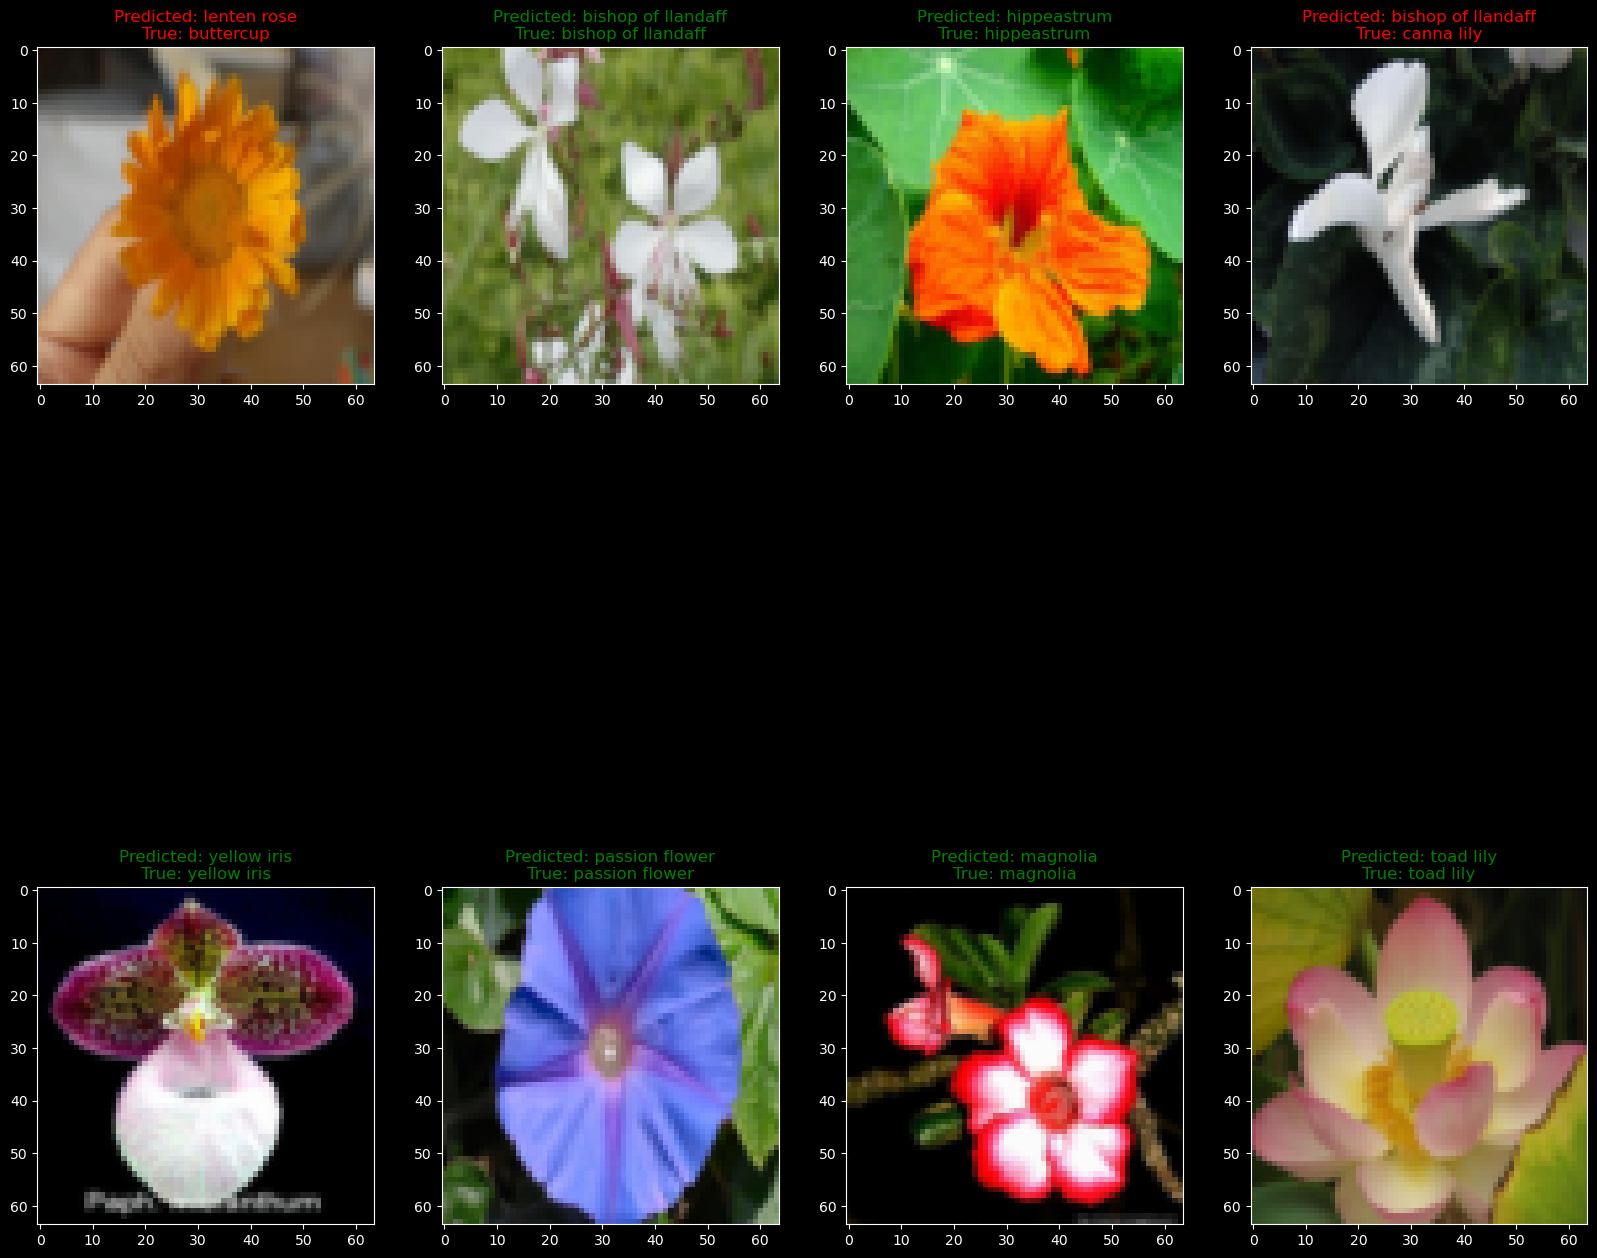

In [101]:
def im_convert(tensor):
    """ 展示数据"""
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

fig=plt.figure(figsize=(20, 20))
columns =4
rows = 2
start_index = 20
for i in range(1, columns*rows +1):
    img = im_convert(images[start_index+i-1])
    ax = fig.add_subplot(rows, columns, i)
    ax.set_title("Predicted: "+cat_to_name[str(preds[start_index+i-1]+1)]+"\n"+"True: "+cat_to_name[str(labels[start_index+i-1]+1)],
                color=("green" if preds[start_index+i-1]==labels[start_index+i-1] else "red"))
    plt.imshow(img)
plt.show()